In [1]:
import numpy as np
import xgboost as xgb
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# collection of machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import model_selection
import pylab as pl
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
pd.set_option("display.max_rows",222200)
pd.set_option("display.max_columns",222200)

In [2]:
train = pd.read_csv('training_set_features.csv')
y_train = pd.read_csv('training_set_labels.csv')
test = pd.read_csv('test.csv')

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

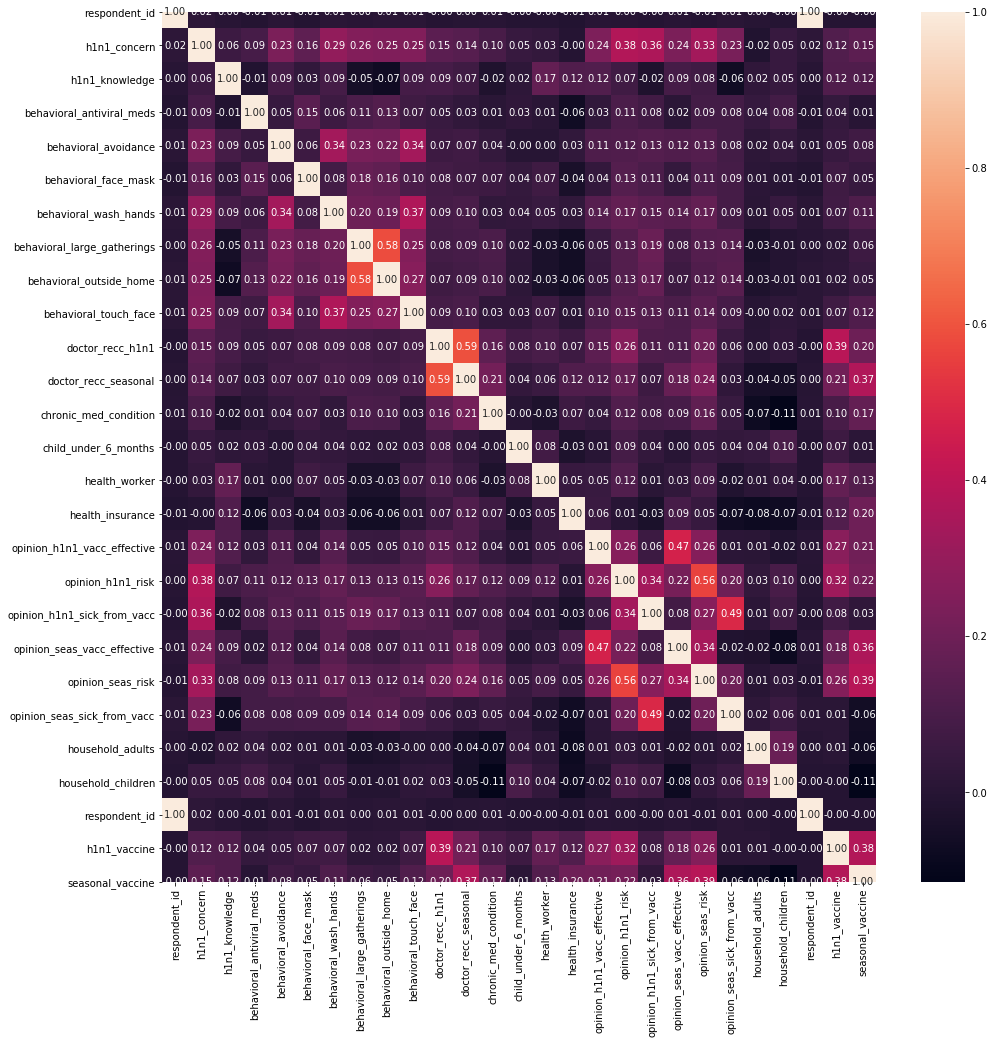

In [3]:
df= pd.concat([train,y_train],axis=1)

print(train.isnull().sum())
print(train.info())
 
plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [4]:
#Binary Verilerin Eksik Verilerini doldurma 
imputer= SimpleImputer( missing_values=np.nan, strategy = 'most_frequent')   
 

binary_train2 = train[["behavioral_antiviral_meds","behavioral_avoidance","behavioral_face_mask",
"behavioral_wash_hands","behavioral_large_gatherings","behavioral_outside_home","behavioral_touch_face",
"doctor_recc_h1n1","doctor_recc_seasonal","chronic_med_condition","child_under_6_months","health_worker",
"health_insurance","sex","marital_status","rent_or_own"]]



imputer = imputer.fit(binary_train2)
binary_train2 = imputer.transform(binary_train2)
binary_train = pd.DataFrame(data =binary_train2 , index=range(26707), columns=["behavioral_antiviral_meds","behavioral_avoidance","behavioral_face_mask",
"behavioral_wash_hands","behavioral_large_gatherings","behavioral_outside_home","behavioral_touch_face",
"doctor_recc_h1n1","doctor_recc_seasonal","chronic_med_condition","child_under_6_months","health_worker",
"health_insurance","sex","marital_status","rent_or_own"])
print(binary_train.isnull().sum())


behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
sex                            0
marital_status                 0
rent_or_own                    0
dtype: int64


In [5]:
#Kategorik Verileri eksik veri bulma
CategorikBasliklar =  train[['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
'age_group','education','race','income_poverty','hhs_geo_region','census_msa','household_adults','household_children',
'employment_industry','employment_occupation','employment_status']]

imputer2= SimpleImputer( missing_values=np.nan, strategy = 'most_frequent') 
imputer2 = imputer.fit(CategorikBasliklar)
CategorikBasliklar = imputer.transform(CategorikBasliklar)
CategorikBasliklar = pd.DataFrame(data =CategorikBasliklar , index=range(26707), columns=['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
'age_group','education','race','income_poverty','hhs_geo_region','census_msa','household_adults','household_children',
'employment_industry','employment_occupation','employment_status'])

In [6]:
#Kategorik verileri one hot encedera çevirme işlemi

ready_cat_data =  pd.get_dummies(CategorikBasliklar , columns =['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
'age_group','education','race','income_poverty','hhs_geo_region','census_msa','household_adults','household_children',
'employment_industry','employment_occupation','employment_status'])


final_df= pd.concat([ready_cat_data,binary_train],axis=1)
y_train.drop(['respondent_id'],axis=1,inplace=True)


In [7]:
###########    TİP DÖNÜŞÜMÜ #############
from sklearn.preprocessing import LabelEncoder
Lb = LabelEncoder()

final_df['sex']= Lb.fit_transform(final_df['sex'])
final_df['marital_status']= Lb.fit_transform(final_df['marital_status'])
final_df['rent_or_own']= Lb.fit_transform(final_df['rent_or_own'])

test['sex']= Lb.fit_transform(test['sex'])
test['marital_status']= Lb.fit_transform(test['marital_status'])
test['rent_or_own']= Lb.fit_transform(test['rent_or_own'])


obj = ["behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask", "behavioral_wash_hands", 
       "behavioral_large_gatherings", "behavioral_outside_home", "behavioral_touch_face", "doctor_recc_h1n1", "doctor_recc_seasonal", 
       "chronic_med_condition", "child_under_6_months", "health_worker", "health_insurance" ]

for i in obj:
    final_df[i] = final_df[i].astype('float')


for i in obj:
    test[i] = test[i].astype('float')

In [8]:
Y1_train = y_train.iloc[:,0:1]
Y2_train = y_train.iloc[:,1:2]

In [89]:
from sklearn.preprocessing import StandardScaler
Scaler1 = StandardScaler()

Y1_train_sc = pd.DataFrame(Scaler1.fit_transform(Y1_train))

In [96]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(final_df, Y1_train_sc, test_size=0.33, random_state=0)

## Torch

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(137, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=137, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [83]:
criterion = nn.CrossEntropyLoss()

In [84]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [100]:
epoch = 200
model.train()
train_loss = 10000000

batch_size = 64
batch_no = len(x1_train) // batch_size

for epoch in range(epoch):  
    for i in range(batch_no):
         
        
        start = i*batch_size
        end = start+batch_size
        
        x_var = Variable(torch.FloatTensor(x1_train[start:end].values))
        y_var = Variable(torch.LongTensor(y1_train.values.squeeze()[start:end]))
        
        optimizer.zero_grad()  
        y_pred = model(x_var)     
        loss = criterion(y_pred, y_var)
        #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    
        loss.backward()
        optimizer.step()
    
        lossVal = loss.item() *1
    if train_loss > lossVal:
        print("Traning loss decreased ({:6f} ===> {:6f}). Saving the model...".format(train_loss,lossVal))
        torch.save(model.state_dict(), "model.pt")
        train_loss = lossVal 
        
model.eval()
x_var_test = Variable(torch.FloatTensor(x1_test.values))
y1_var_test = Variable(torch.LongTensor(y1_test.values.squeeze()))
y_pred_test = model(x_var_test)
after_train = criterion(y_pred_test.squeeze(), y1_var_test ) 
print('Test loss ' , after_train.item())

Traning loss decreased (10000000.000000 ===> 0.461742). Saving the model...
Traning loss decreased (0.461742 ===> 0.434197). Saving the model...
Traning loss decreased (0.434197 ===> 0.421796). Saving the model...
Traning loss decreased (0.421796 ===> 0.406595). Saving the model...
Traning loss decreased (0.406595 ===> 0.400983). Saving the model...
Traning loss decreased (0.400983 ===> 0.387992). Saving the model...
Traning loss decreased (0.387992 ===> 0.381156). Saving the model...
Traning loss decreased (0.381156 ===> 0.376519). Saving the model...
Traning loss decreased (0.376519 ===> 0.375893). Saving the model...
Traning loss decreased (0.375893 ===> 0.369736). Saving the model...
Traning loss decreased (0.369736 ===> 0.356301). Saving the model...
Traning loss decreased (0.356301 ===> 0.350713). Saving the model...
Traning loss decreased (0.350713 ===> 0.324159). Saving the model...
Traning loss decreased (0.324159 ===> 0.321334). Saving the model...
Traning loss decreased (0.3

In [106]:
x_var_test = Variable(torch.FloatTensor(x1_test.values))

with torch.no_grad():
    test_result = model(x_var_test)
values, labels = torch.max(test_result, 1)

after_train = criterion(labels, y1_var_test ) 
print('Test loss ' , after_train.item())

In [116]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels.numpy(),y1_var_test.numpy() )

array([[6393, 1088],
       [ 498,  835]], dtype=int64)

In [115]:
y1_var_test.numpy() 8814

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [17]:
torch.set_printoptions(threshold=50000000) 

In [112]:
after_train = criterion(labels.squeeze(), y1_var_test ) 
print('Test loss ' , after_train.item())

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)